<a href="https://colab.research.google.com/github/dralvima/IITmethods/blob/main/ChatGPT4Worm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Read in data from: https://www.wormwideweb.org/dataset.html

In [1]:
from google.colab import files
import json

# Step 1: Upload the JSON file (to start, let's use: 2023-01-23-21)
uploaded = files.upload()

# Step 2: Read the JSON file
file_name = next(iter(uploaded))
rawdata = json.loads(uploaded[file_name].decode("utf-8"))

# Step 3: Access the z-scored ratiometric neural data
data = {}
data['neurodata'] = rawdata.get('trace_array', None)
data['neurolabels'] = rawdata.get('labeled', None)

# Check if both 'neurodata' and 'neurolabels' were found and print a message
if data['neurodata'] is not None and data['neurolabels'] is not None:
    print("Neural data detected")
else:
    print("Neural data not found in the JSON file.")

Saving 2023-01-23-21.json to 2023-01-23-21.json
Neural data detected


throw out what we do not need and save new variable

In [2]:
# Step 4: Save the 'data' variable to a JSON file
with open('data.json', 'w') as file:
    json.dump(data, file)

print("Data saved to 'data.json'")
del rawdata

Data saved to 'data.json'


# 2. Select 3 Neurons:
see
https://funconn.princeton.edu/
for functional connectivity
and
https://www.wormatlas.org/neurons/Individual%20Neurons/Neuronframeset.html
for details
[one Hebbian synapse for this dataset is: AVEL -> AIBL <- RIAR]

Enter the labels of three neurons. Available neuron labels:
AVEL, RMEL, AWAR, URYDL, I2L, SAAVL, I1R, RMDR, IL1DL, URYDR, SIBVL, RMER, SMDVR, RIAR, SAADL, M3R, RICR, AIM?, ADAL, RMDVR, AIBL, SMBV?, RMF?, OLQVL, RMEV, OLLL, RMDL, RMDDL, NSMR, AIZL, AVDR, URXR, AIZR, AVAL, IL2DL, RID, AQR, CEPDL, AVAR, RIBL, I2R, AVDL, AVJR, IL2L, NSML, AINR, RIMR, M4, IL1V?, AIYR, CEPVL, IL2R, AWCR, AWBR, OLQDR, IL1L, URYVR, MCR, AUAL, AWAL, RMDVL, RMGL, M3L, IL2VL, FLPL, AVER, RIVR, I3, AIBR, RMDDR, I1L, URXL, CEPVR, IL1V?, IL1DR, OLQDL, IL2VR, SMBV?, RMED, URBL, ASGL, ASHL, M5, AVJL, SMDVL, OLLR, RIVL, IL1R, MI, ADEL, URYVL, AWCL, AINL, MCL, AIYL, AVHL, ASGR, CEPDR, M1, RMF?, RICL, URBR
Enter neuron label 1: AVEL
Enter neuron label 2: AWAR
Enter neuron label 3: AIM?


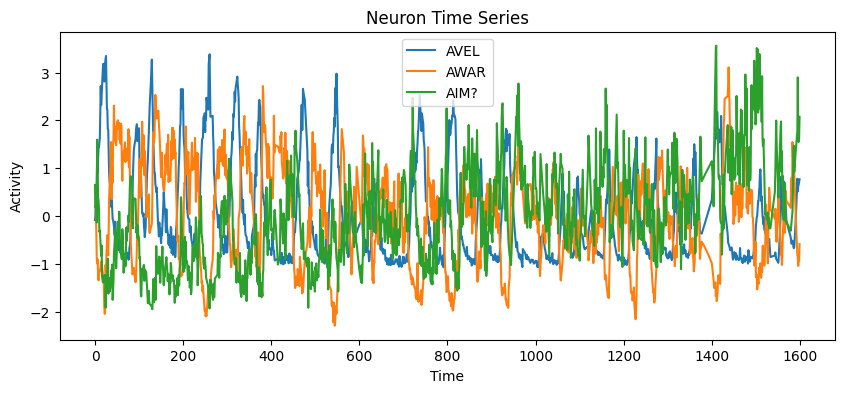

In [3]:
import matplotlib.pyplot as plt

# Extract neuron labels and time series data
neuron_labels = {key: value['label'] for key, value in data['neurolabels'].items()}
neuron_data = data['neurodata']

# Function to plot the selected neurons' time series
def plot_neuron_data(selected_neurons):
    plt.figure(figsize=(10, 4))
    for neuron in selected_neurons:
        neuron_index = list(neuron_labels.values()).index(neuron)
        plt.plot(neuron_data[neuron_index], label=neuron)
    plt.xlabel('Time')
    plt.ylabel('Activity')
    plt.title('Neuron Time Series')
    plt.legend()
    plt.show()

# Use input fields in Colab to select neurons
print("Enter the labels of three neurons. Available neuron labels:")
print(', '.join(neuron_labels.values()))  # Display all neuron labels

selected_neurons = []
for i in range(3):
    neuron = input(f"Enter neuron label {i+1}: ")
    if neuron in neuron_labels.values():
        selected_neurons.append(neuron)
    else:
        print(f"Neuron {neuron} not found. Please try again.")

# Plot the time series for the selected neurons
if len(selected_neurons) == 3:
    plot_neuron_data(selected_neurons)
else:
    print("Insufficient neurons selected for plotting.")


# 3. Plot cross-correlograms

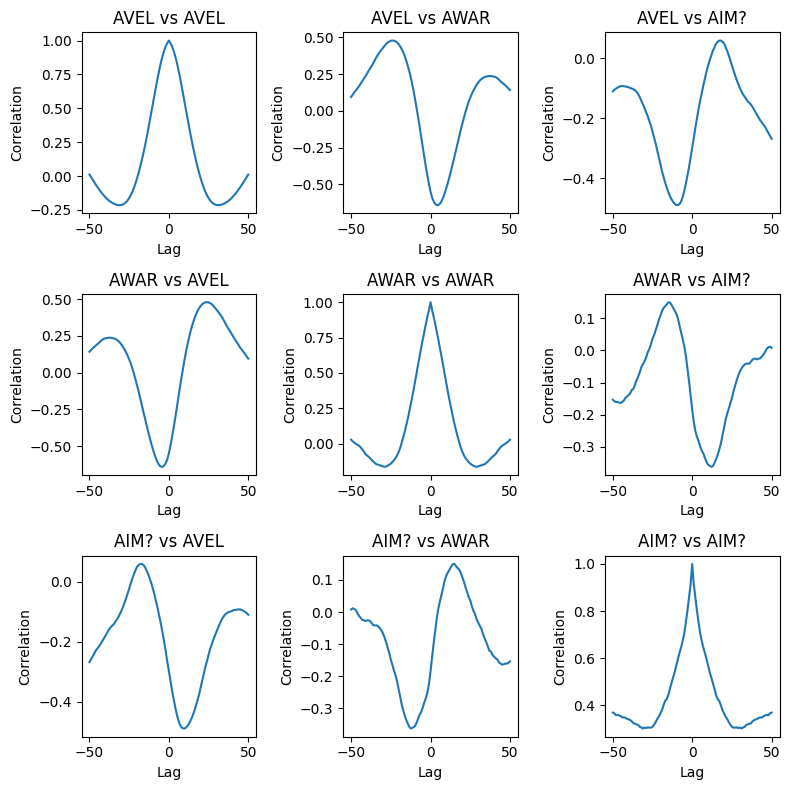

In [4]:
import numpy as np

def compute_cross_correlation(signal1, signal2, max_lag):
    """
    Compute the cross-correlation between two signals with a specified maximum lag.
    The function returns the cross-correlation and the corresponding lags.
    """
    correlation = np.correlate(signal1 - np.mean(signal1), signal2 - np.mean(signal2), mode='full')
    correlation /= np.std(signal1) * np.std(signal2) * len(signal1)
    lags = np.arange(-max_lag, max_lag + 1)
    return correlation[len(correlation)//2 - max_lag: len(correlation)//2 + max_lag + 1], lags

# Define the maximum lag for the cross-correlation
max_lag = 50  # This value might need adjustment based on the time scale of your data

# Create a grid for the subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

# For each pair of neurons, compute and plot the cross-correlation
for i, neuron1 in enumerate(selected_neurons):
    for j, neuron2 in enumerate(selected_neurons):
        ax = axes[i, j]
        # Find indices of the neurons
        neuron_index1 = list(neuron_labels.values()).index(neuron1)
        neuron_index2 = list(neuron_labels.values()).index(neuron2)

        # Compute cross-correlation
        correlation, lags = compute_cross_correlation(neuron_data[neuron_index1], neuron_data[neuron_index2], max_lag)

        # Plot the cross-correlation
        ax.plot(lags, correlation)
        ax.set_title(f'{neuron1} vs {neuron2}')
        ax.set_xlabel('Lag')
        ax.set_ylabel('Correlation')

plt.tight_layout()
plt.show()

# **4. De-Conolve Ca2+ --> SPIKES**

using *OASIS*:


    Friedrich J, Paninski L. Fast Active Set Method for Online Spike Inference from Calcium Imaging. In: Adv Neural Inf Process Syst. 2016; p. 1984–1992.

    Friedrich J, Zhou P, Paninski L. Fast Online Deconvolution of Calcium Imaging Data. PLoS Comput Biol. 2017; 13(3):e1005423.


In [5]:
# install: OASIS (https://github.com/j-friedrich/OASIS);
# this is the algorithm used in CaImAn (https://github.com/flatironinstitute/CaImAn)
!pip install oasis-deconv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.6/249.6 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for oasis-deconv: filename=oasis_deconv-0.2.0-cp310-cp310-linux_x86_64.whl size=1310887 sha256=76971a6187492d95ee64adb199d4fe46e9eaac8f69ed9a506e311f54f52d481e
  Stored in directory: /root/.cache/pip/wheels/fe/61/6d/e9112c665494a2bd0756a3419d711940c6299d7576706af36e
Successfully built oasis-deconv


set up OASIS

In [6]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sys import path
path.append('..')
from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
from oasis.plotting import simpleaxis
from oasis.oasis_methods import oasisAR1, oasisAR2
!apt install texlive texlive-xetex texlive-latex-extra pandoc
!apt install cm-super
!apt install dvipng

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
pandoc set to manually installed.
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6
  libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils teckit tex-common tex-gyre
  texlive-base texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fo

# **De-Convolve**

CPU times: user 33.1 ms, sys: 18 ms, total: 51.1 ms
Wall time: 28.5 ms


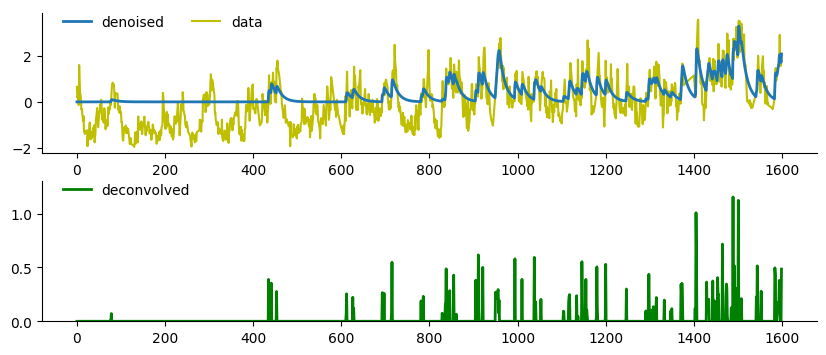

In [19]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sys import path
path.append('..')
from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
from oasis.plotting import simpleaxis
from oasis.oasis_methods import oasisAR1, oasisAR2


def plot_trace():
    plt.figure(figsize=(10,4))
    plt.subplot(211)
    plt.plot(b+c, lw=2, label='denoised')
    plt.plot(y, label='data', zorder=-12, c='y')
    plt.legend(ncol=3, frameon=False, loc=(.02,.85))
    simpleaxis(plt.gca())
    plt.subplot(212)
    plt.plot(s, lw=2, label='deconvolved', c='g')
    plt.ylim(0,1.3)
    plt.legend(ncol=3, frameon=False, loc=(.02,.85));
    simpleaxis(plt.gca())


# convert python list to np.array
ca_list = neuron_data[neuron_index1]
y = np.array(ca_list)

# de-convolve
%time c, s, b, g, lam = deconvolve(y, g=(None,None), penalty=1)

# plot
plot_trace()